# Introduction

First, the references (Thank you!): 

 - Baseline: [[SenNet + HOA] Train - UNet simple baseline](https://www.kaggle.com/code/kashiwaba/sennet-hoa-inference-unet-simple-baseline)
 - Generating Sub-volumes: [2d-to-3d unet demo](https://www.kaggle.com/code/hengck23/2d-to-3d-unet-demo)
 - Augmentations: [PyTorch Dataset with Volumetric Augmentations](https://www.kaggle.com/code/limitz/pytorch-dataset-with-volumetric-augmentations)
 - Some more bits and pieces: [2.5d Cutting model baseline [training]](https://www.kaggle.com/code/yoyobar/2-5d-cutting-model-baseline-training)

Hello and good day! I'm new to kaggle contests and this is my first public notebook. Looking forward to learning more from your comments ^_^

# Imports

In [1]:
!pip install -q segmentation_models_pytorch

In [2]:
import os
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
from glob import glob
import gc
import time
from collections import defaultdict
import  matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import copy
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.cuda import amp
import torch.optim as optim
import albumentations as A
import segmentation_models_pytorch as smp
from PIL import Image
import torchvision.transforms as T

import math
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class CFG:
    seed          = 42
    debug         = True # set debug=False for Full Training
#     exp_name      = 'baseline'
#     comment       = 'unet-se_resnext50_32x4d-512x512'
#     output_dir    = './'
#     model_name    = 'Unet'
#     backbone      = 'se_resnext50_32x4d'
    train_bs      = 1
    valid_bs      = 1
    subvlm_size   = 256 # Height and Width of each sub-volume
    subvlm_depth  = 64
    overlap       = 16  # Overlap between sub-volumes
    epochs        = 5
    n_accumulate  = max(1, 4//train_bs)
    lr            = 6e-5
    scheduler     = 'OneCycleLR'
#     min_lr        = 1e-7
#     T_max         = int(2279/(train_bs*n_accumulate)*epochs)+50
#     T_0           = 25
#     warmup_epochs = 3
#     wd            = 1e-6
#     n_fold        = 5
#     num_classes   = 1
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    gt_df = "/kaggle/input/sennet-hoa-gt-data/gt.csv"
    data_root = "/kaggle/input"
    train_groups = ["kidney_1_dense"]
    valid_groups = ["kidney_3_dense"]
    loss_func     = "BCELoss"

#     data_transforms = {
#         "train": T.Compose([
#             T.ToTensor(),
#         ]),
#         "valid": T.Compose([
#             T.ToTensor(),
#         ]),
#     }

In [4]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(CFG.seed)

# DataLoader

### **Note**
* I wrote this dataloader based on the [2d-to-3d demo notebook](https://www.kaggle.com/code/hengck23/2d-to-3d-unet-demo). Currently it returns subvolumes of shape CxDxHxW. 
* I volume-normalized the data as there were some overflow errors when directly casting to float16 and the existing ones did instance-based normalizing. [Link to Dataset](https://www.kaggle.com/datasets/tahseenislamsajon/sennet-hoa-train-normalized-png)
* Only using RandomFlip for now as the dimensions used are not uniform. From the discussions [here](https://www.kaggle.com/competitions/blood-vessel-segmentation/discussion/456118#2557825), I inferred that 64x256x256 should be a minimum. So a good choice may be 256x256x256, but it will take too much memory. 

In [5]:
def norm_by_percentile(x, low=10, high=99.8, alpha=0.01):
	xmin = np.percentile(x, low)
	xmax = np.percentile(x, high)
	x = (x - xmin) / (xmax - xmin)
	if 1:
		x[x > 1] = (x[x > 1] - 1) * alpha + 1
		x[x < 0] = (x[x < 0]) * alpha
	# x = np.clip(x,0,1)
	return x

In [6]:
class OverlappingVolumeDataset(Dataset):
    def __init__(self, images_paths, labels_paths, depth, size, overlap, transform=None):
        
        self.images_paths = sorted(images_paths)
        self.labels_paths = sorted(labels_paths)
        self.depth = depth
        self.size = size
        self.overlap = overlap
        self.transform = transform

        self.full_volume, self.full_label = self.load_full_volume()

        # Calculate number of sub-volumes
        D, H, W = self.full_volume.shape
        num_D = int(np.ceil((D - overlap) / (depth - overlap)))
        num_H = int(np.ceil((H - overlap) / (size - overlap)))
        num_W = int(np.ceil((W - overlap) / (size - overlap)))

        # Calculate sub-volume indices 
        self.zz = np.linspace(0, D-depth, num_D).astype(int).tolist()
        self.yy = np.linspace(0, H-size, num_H).astype(int).tolist()
        self.xx = np.linspace(0, W-size, num_W).astype(int).tolist()

    def load_full_volume(self):
        images = [cv2.imread(f, cv2.IMREAD_GRAYSCALE).astype('float16') for f in self.images_paths]
        volume = np.stack(images)
        # norm not being used here since the data i'm using is already normalized
#         volume = norm_by_percentile(volume)
        volume = volume / 255.0
        del images
        
        labels = [cv2.imread(f, cv2.IMREAD_GRAYSCALE).astype('float16') for f in self.labels_paths]
        label = np.stack(labels)
        label = label / 255.0
        del labels
        
        return volume, label

    def __len__(self):
        return len(self.zz) * len(self.yy) * len(self.xx)

    def __getitem__(self, idx):
        D_idx = idx // (len(self.yy) * len(self.xx))
        H_idx = (idx // len(self.xx)) % len(self.yy)
        W_idx = idx % len(self.xx)

        z, y, x = self.zz[D_idx], self.yy[H_idx], self.xx[W_idx]
        image = self.full_volume[z:z + self.depth, y:y + self.size, x:x + self.size]
        label = self.full_label[z:z + self.depth, y:y + self.size, x:x + self.size]

        image = np.expand_dims(image, axis = 0)
        label = np.expand_dims(label, axis = 0)

        image = torch.from_numpy(image).to(torch.float32)
        label = torch.from_numpy(label).to(torch.float32)

        if self.transform:
            rng = torch.get_rng_state()
            image = self.transform(image)
            torch.set_rng_state(rng)
            label = self.transform(label)

        return image, label


In [7]:
# The augmentations. source: https://www.kaggle.com/code/limitz/pytorch-dataset-with-volumetric-augmentations

class RandomRotationNd(nn.Module):
    ''' This augmentation first permutes the dimensions as an initial rotation
        to select the rotation axis, then rotates around the (fixed) z axis.
        The result is zoomed in to remove empty space and finally permuted
        once more to move randomize the rotation axis.
    '''
    def __init__(self, dims):
        super().__init__()
        self.dims = dims

    def forward(self, x):
        angle = torch.rand(1).item() * 360
        keep = torch.arange(x.dim() - self.dims)
        perm = -torch.randperm(self.dims)-1
        x = x.clone().permute(*[k.item() for k in keep], *[p.item() for p in perm])
        rad = math.pi * angle / 180
        scale = abs(math.sin(rad)) + abs(math.cos(rad))
        for i in range(0, x.shape[-3],8): # presumptuous
            v = x[...,i:i+8,:,:]
            w = v.view(-1, *v.shape[-3:])
            w = TF.rotate(w, angle)
            v = w.view(*v.shape)
            x[...,i:i+8,:,:] = v
        s = x.shape
        x = F.interpolate(x, scale_factor=scale, mode="bilinear")
        x = TF.center_crop(x, s[-2:])
        perm = -torch.randperm(self.dims)-1
        x = x.permute(*[k.item() for k in keep], *[p.item() for p in perm])
        return x

class RandomRot90Nd(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.dims = dims

    def forward(self, x):
        dims = -torch.randperm(self.dims)[:2]-1
        dims = [d.item() for d in dims]
        rot = torch.randint(4, (1,)).item()
        return x.rot90(rot, dims)

class RandomPermuteNd(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.dims = dims

    def forward(self, x):
        perm = -torch.randperm(self.dims)-1
        keep = torch.arange(x.dim() - self.dims)
        return x.permute(*[k.item() for k in keep], *[p.item() for p in perm])

class RandomFlipNd(nn.Module):
    def  __init__(self, dims, p=0.5):
        super().__init__()
        self.dims = dims
        self.p = p

    def forward(self, x):
        for i in range(self.dims):
            if torch.rand(1) < self.p:
                x = x.flip(-i-1)
        return x

class ToDevice(nn.Module):
    ''' Sometimes it helps to move the tensor to the gpu before augmentations like
        rotation. Note however that you need to set num_workers to 0 in the dataloader
    '''
    def __init__(self, device=None):
        super().__init__()
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x):
        return x.to(self.device)


In [8]:
# chose RandomFlipNd only because the the 3 spatial dimensions are not the same
train_transforms = T.Compose((ToDevice(), RandomFlipNd(3)))

valid_transforms = T.Compose((ToDevice(), ))

In [9]:
train_groups = CFG.train_groups
valid_groups = CFG.valid_groups
gt_df = pd.read_csv(CFG.gt_df)
gt_df["img_path"] = gt_df["img_path"].apply(lambda x: os.path.join(CFG.data_root, x)).apply(lambda x: x.replace('blood-vessel-segmentation/train', 'sennet-hoa-train-normalized-png').replace('.tif', '.png'))
gt_df["msk_path"] = gt_df["msk_path"].apply(lambda x: os.path.join(CFG.data_root, x)).apply(lambda x: x.replace('blood-vessel-segmentation/train', 'sennet-hoa-train-normalized-png').replace('.tif', '.png'))
train_df = gt_df.query("group in @train_groups").reset_index(drop=True)
valid_df = gt_df.query("group in @valid_groups").reset_index(drop=True)
train_img_paths = train_df["img_path"].values.tolist()
train_msk_paths = train_df["msk_path"].values.tolist()
valid_img_paths = valid_df["img_path"].values.tolist()
valid_msk_paths = valid_df["msk_path"].values.tolist()
if CFG.debug:
    train_img_paths = train_img_paths[150:150+CFG.train_bs*CFG.subvlm_depth*3]
    train_msk_paths = train_msk_paths[150:150+CFG.train_bs*CFG.subvlm_depth*3]
    valid_img_paths = valid_img_paths[150:150+CFG.valid_bs*CFG.subvlm_depth*2]
    valid_msk_paths = valid_msk_paths[150:150+CFG.valid_bs*CFG.subvlm_depth*2]

In [10]:
train_dataset = OverlappingVolumeDataset(
                    images_paths=train_img_paths,
                    labels_paths=train_msk_paths,
                    depth=CFG.subvlm_depth, size=CFG.subvlm_size, overlap=CFG.overlap,
                    transform=train_transforms
                )

In [11]:
valid_dataset = OverlappingVolumeDataset(
                    images_paths=valid_img_paths,
                    labels_paths=valid_msk_paths,
                    depth=CFG.subvlm_depth, size=CFG.subvlm_size, overlap=CFG.overlap,
                    transform=valid_transforms
                )

In [12]:
train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, num_workers=0, shuffle=True, pin_memory=False)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, num_workers=0, shuffle=False, pin_memory=False)

### Check Augmentations

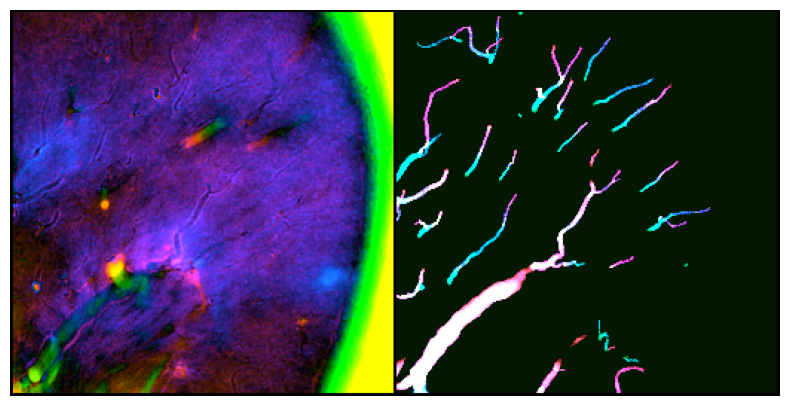

For show: more augmentation of the same subvolume


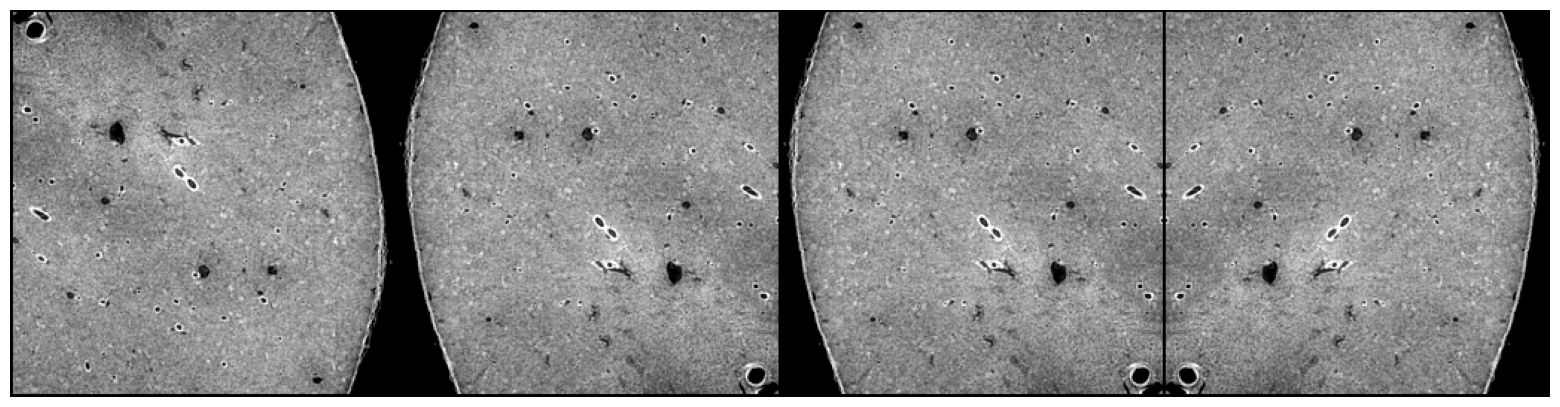

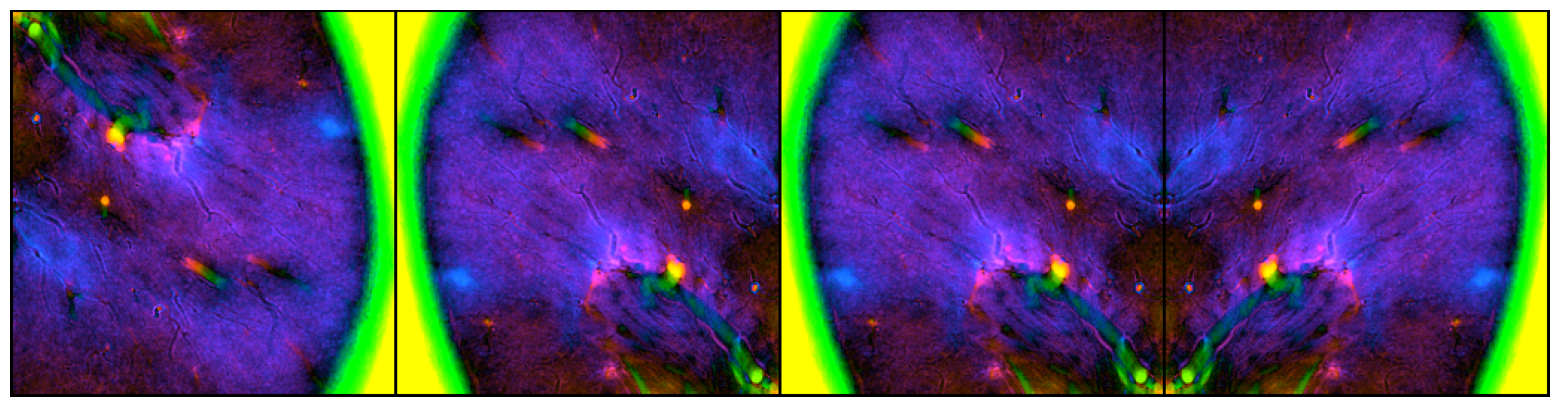

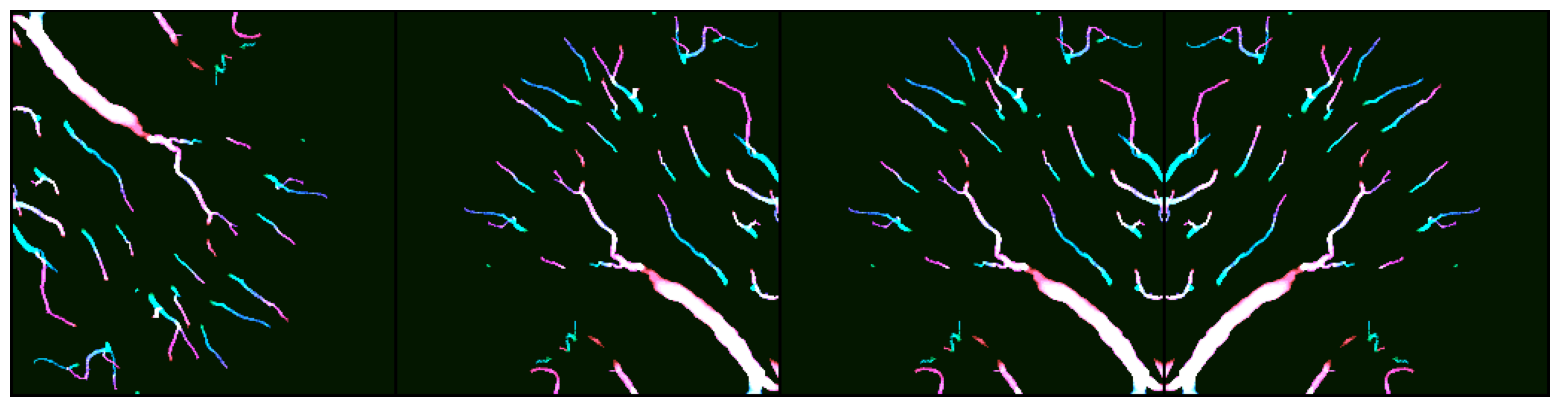

In [13]:
import inline

volume, target = train_dataset[30]

volume = volume.sub(volume.mean()).div(volume.std().add(1e-5))
inline.plot(torch.stack((inline.disp(volume[0]), inline.disp(target[0]))), width=10)

print("For show: more augmentation of the same subvolume")
# Showing the same subvolume, with random flips
rot = RandomFlipNd(3)
rng = torch.get_rng_state()
volumes = torch.stack([rot(volume)[0] for _ in range(4)])
torch.set_rng_state(rng)
targets = torch.stack([rot(target)[0] for _ in range(4)])
inline.plot(volumes.mul(0.288).add(0.5)[:,[32]])
inline.plot(volumes)
inline.plot(targets)

# Model - Using Monai 

In [14]:
!pip install -q monai[einops]

In [15]:
from monai.networks.nets import UNETR

model = UNETR(
    in_channels=1,
    out_channels=1,
    img_size=(64, 256, 256),  
)

model.to(CFG.device)

UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Conv3d(1, 768, kernel_size=(16, 16, 16), stride=(16, 16, 16))
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (input_rearrange): Rearrange('b h (qkv l d) -> qkv b l h d', qkv=3, l=12)
          (out_rearrange): Rearrange('b h l d -> b l (h d)')
          (drop_out

In [16]:
def run_check_net():
    for subvolume, label in train_loader:
        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=True):
                vessel = model(subvolume)

        print(subvolume.shape)
        print(label.shape)

        print('output')
        print(vessel.shape)

#         del vessel, subvolume, label, net
        break

run_check_net()

torch.Size([1, 1, 64, 256, 256])
torch.Size([1, 1, 64, 256, 256])
output
torch.Size([1, 1, 64, 256, 256])


# Loss Function

In [17]:
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = nn.BCEWithLogitsLoss()
def criterion(y_pred, y_true):
    if CFG.loss_func == "DiceLoss":
        return DiceLoss(y_pred, y_true)
    elif CFG.loss_func == "BCELoss":
        return BCELoss(y_pred, y_true)

# Metrics

In [18]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3,4), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3,4), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

# Optimizer

In [19]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max,
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0,
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduler == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

    elif CFG.scheduler == 'OneCycleLR':
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=CFG.epochs)

    elif CFG.scheduler == None:
        return None

    return scheduler

In [20]:
optimizer = optim.AdamW(model.parameters(), lr=CFG.lr)
scheduler = fetch_scheduler(optimizer)

### Check LR

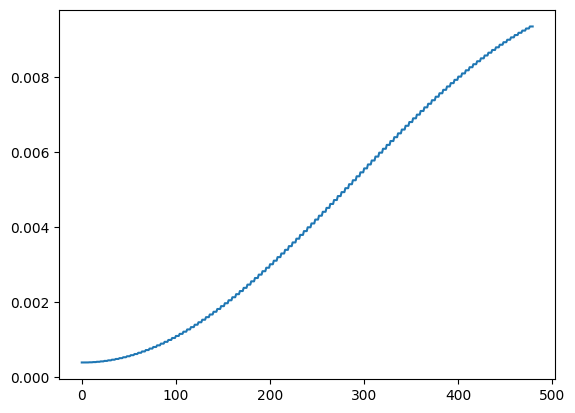

In [21]:
_optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
_scheduler = fetch_scheduler(_optimizer)
lr_list = []
for e in range(CFG.epochs):
    for step in range(len(train_loader)):
        lr_list.append(_optimizer.param_groups[0]['lr'])
        if (step + 1) % CFG.n_accumulate == 0:
            _optimizer.step()
            _scheduler.step()
plt.plot(np.array(range(len(lr_list))), np.array(lr_list))
plt.show()
del _optimizer, _scheduler

# Training Function

In [22]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()

    dataset_size = 0
    running_loss = 0.0

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:

        batch_size = images.size(0)

        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate

        scaler.scale(loss).backward()

        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix( epoch=f'{epoch}',
                          train_loss=f'{epoch_loss:0.4f}',
                          lr=f'{current_lr:0.5f}',
                          gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss

In [23]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0

    val_scores = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:

        batch_size = images.size(0)

        y_pred  = model(images)
        loss    = criterion(y_pred, masks)

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss, val_scores

In [24]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss      = np.inf
    best_epoch     = -1
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler,
                                           dataloader=train_loader,
                                           device=CFG.device, epoch=epoch)

        val_loss, val_scores = valid_one_epoch(model, valid_loader,
                                                 device=CFG.device,
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        print(f'Valid Loss: {val_loss}')

        # deep copy the model
        if val_loss <= best_loss:
            print(f"{c_}Valid loss Improved ({best_loss} ---> {val_loss})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_loss = val_loss
            best_epoch   = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "best_epoch.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved{sr_}")

        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = "last_epoch.bin"
        torch.save(model.state_dict(), PATH)

        print(); print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Train

In [25]:
model, history = run_training(model, optimizer, scheduler,
                                device=CFG.device,
                                num_epochs=CFG.epochs
                             )

cuda: Tesla P100-PCIE-16GB

Epoch 1/5

Valid : 100%|██████████| 168/168 [01:07<00:00,  2.49it/s, gpu_memory=4.50 GB, lr=0.00105, valid_loss=0.4264]


Valid Dice: 0.0270 | Valid Jaccard: 0.0144
Valid Loss: 0.4263958102535634
Valid loss Improved (inf ---> 0.4263958102535634)
Model Saved


Epoch 2/5

Valid : 100%|██████████| 168/168 [01:06<00:00,  2.52it/s, gpu_memory=4.55 GB, lr=0.00283, valid_loss=0.2640]


Valid Dice: 0.0180 | Valid Jaccard: 0.0179
Valid Loss: 0.2639900605593409
Valid loss Improved (0.4263958102535634 ---> 0.2639900605593409)
Model Saved


Epoch 3/5

Valid : 100%|██████████| 168/168 [01:06<00:00,  2.52it/s, gpu_memory=4.59 GB, lr=0.00525, valid_loss=0.1302]


Valid Dice: 0.4286 | Valid Jaccard: 0.4286
Valid Loss: 0.13023836369670572
Valid loss Improved (0.2639900605593409 ---> 0.13023836369670572)
Model Saved


Epoch 4/5

Valid : 100%|██████████| 168/168 [01:07<00:00,  2.51it/s, gpu_memory=4.45 GB, lr=0.00766, valid_loss=0.0594]


Valid Dice: 0.5417 | Valid Jaccard: 0.5417
Valid Loss: 0.059439516094114096
Valid loss Improved (0.13023836369670572 ---> 0.059439516094114096)
Model Saved


Epoch 5/5

Valid : 100%|██████████| 168/168 [01:07<00:00,  2.50it/s, gpu_memory=4.51 GB, lr=0.00940, valid_loss=0.0486]


Valid Dice: 0.5417 | Valid Jaccard: 0.5417
Valid Loss: 0.04864347544276998
Valid loss Improved (0.059439516094114096 ---> 0.04864347544276998)
Model Saved


Training complete in 0h 15m 49s
Best Loss: 0.0486
